# Project 2 - Trading Meme Stocks

## Imports, environment variables and keys 

In [86]:
import requests
import os
import pandas as pd
import time
from datetime import date
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
import pandas_ta as ta

In [ ]:
# Load environment variables
load_dotenv()

#Set API Key from env variable
ss_key=os.getenv("SS_API_KEY")

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

## Helper Functions

In [ ]:
def get_sentiment_df():
    headers = {
        'Authorization' : f'Token {ss_key}',
        'Accept': 'application/json',
    }

    sentiment_response = requests.get('https://socialsentiment.io/api/v1/stocks/sentiment/daily/', headers=headers)
    sentiment_dict = sentiment_response.json()['results']
    sentiment_df = pd.DataFrame.from_dict(sentiment_dict)
    line_count = sentiment_response.json()['count']
    page_count = int(line_count / 50) + (line_count % 50 > 0)
    page=2

    while page <= page_count:
        # Loop through all pages available from API and construct dataframe for sentiment data
        sentiment_url = "https://socialsentiment.io/api/v1/stocks/sentiment/daily/?page=%s"%page
        sentiment_response = requests.get(sentiment_url, headers=headers)
        sentiment_dict = sentiment_response.json()['results']
        sentiment_df_loop = pd.json_normalize(sentiment_dict)
        sentiment_df = pd.concat([sentiment_df, sentiment_df_loop], axis=0)
        page += 1
        time.sleep(1)

    sentiment_df.reset_index(inplace=True, drop=True)
    path = (f'../Resources/sentiment_{date.today()}.csv')
    sentiment_df.to_csv(path)
    return sentiment_df

In [ ]:
def get_sentiment_trending_df():
    headers = {
        'Authorization' : f'Token {ss_key}',
        'Accept': 'application/json',
    }
    trending_response = requests.get('https://socialsentiment.io/api/v1/stocks/trending/daily/', headers=headers)
    trending_dict = trending_response.json()
    trending_df = pd.DataFrame.from_dict(trending_dict)
    path = (f'../Resources/sentiment_trending_{date.today()}.csv')
    trending_df.to_csv(path)
    return trending_df

## Fundemental Analysis

In [ ]:
sentiment_df = get_sentiment_df()
sentiment_df.head()

In [ ]:
sentiment_trending_df = get_sentiment_trending_df()
sentiment_trending_df.head()

These functions return 2 data frames with useful data. Need to discuss as a team what we target as our metrics. 

For example it could be any of the following
1. Top 10 stocks with highest overall sentiment score
2. Top 10 most improved sentiment
3. Top 10 positive sentiment
4. Greated jump in sentiment from long to short term

In [ ]:
# Until we decide exatcly what features of the functional analysis we will use, I have proceeded to TA just using top 10 sentiment scores for stocks
top_stocks = sentiment_df.sort_values("score", ascending=False).head(10)
top_stocks

## Technical Analysis

In [153]:
# Create the Alpaca API object, specifying use of the paper trading account:
api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    base_url = 'https://paper-api.alpaca.markets',
    api_version = "v2"
)

In [172]:
# Get tickers for top 10 stocks from FA
ticker_list = top_stocks["stock"]

# declare begin and end date strings
beg_date = '2020-03-04'
end_date = '2022-03-04'
# we convert begin and end date to formats that the ALPACA API requires
start =  pd.Timestamp(f'{beg_date} 09:30:00-0400', tz='America/New_York').replace(hour=9, minute=30, second=0).astimezone('GMT').isoformat()[:-6]+'Z'
end   =  pd.Timestamp(f'{end_date} 16:00:00-0400', tz='America/New_York').replace(hour=16, minute=0, second=0).astimezone('GMT').isoformat()[:-6]+'Z'
# We set the time frequency at which we want to pull prices
timeframe='1Day'

# Pull prices from the ALPACA API
stocks_ohlcv = api.get_bars(ticker_list, timeframe, start=start, end=end).df

In [173]:
close_df = pd.DataFrame(index=stocks_ohlcv.index)

for ticker in ticker_list:
    vector = stocks_ohlcv.loc[stocks_ohlcv["symbol"] == ticker].close
    close_df[ticker] = vector

close_df.dropna(axis=1, how='all', inplace=True)

In [174]:
close_df.head()

,WB,TWNK,NTES,PLTR,PYPL,BIDU,VMW,ORCL,SHOP
timestamp,,,,,,,,,
2020-03-05 05:00:00+00:00,43.46,12.74,341.42,NaN,112.18,118.33,121.88,48.00,498.22
2020-03-06 05:00:00+00:00,41.96,12.69,336.21,NaN,110.91,113.74,117.13,47.37,472.07
2020-03-09 04:00:00+00:00,39.75,12.13,321.25,NaN,101.63,106.65,109.45,46.01,418.32
2020-03-10 04:00:00+00:00,41.82,11.83,324.71,NaN,109.74,111.91,113.84,48.58,450.34
2020-03-11 04:00:00+00:00,39.78,11.60,324.10,NaN,103.90,108.25,106.01,44.72,422.31


In [175]:
# Define a variable to set prediction period
forecast = 1

# Compute the pct_change for 1 min 
returns = close_df.pct_change(periods=forecast)

# Shift the returns to convert them to forward returns
returns = returns.shift(-(forecast))

<AxesSubplot:title={'center':'Cumulative Returns'}, xlabel='timestamp'>

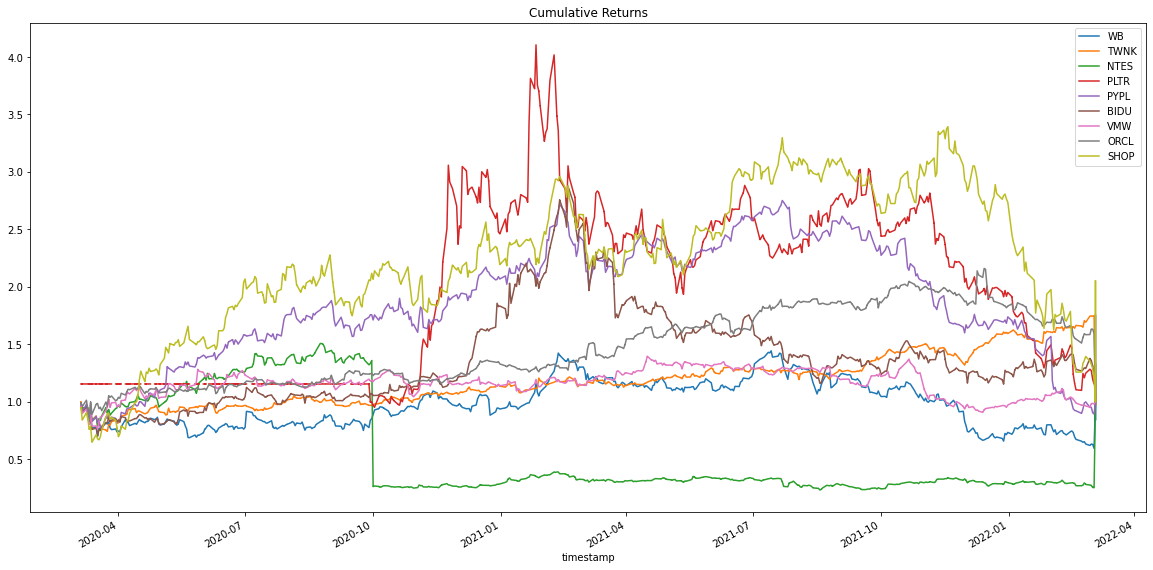

In [181]:
#Calculate cumulative returns
cumulative_returns = (1 + returns).cumprod()

#Plot cumulative returns
cumulative_returns.plot(figsize=(20,10), title = "Cumulative Returns")

In [176]:
# Use unstack() to bring the data in long format and save the output as as dataframe
unstack_returns = pd.DataFrame(returns.unstack(level=0))

# Rename the column to make it easer to identify it:
name = f'F_{forecast}_d_returns'
unstack_returns.rename(columns={0: name}, inplace = True)

# Reset the index of the dataframe for merging later (be sure to set inplace=True)
unstack_returns.reset_index(inplace=True)

unstack_returns["EMA7"] = ta.ema(unstack_returns["F_1_d_returns"], length=7)
unstack_returns["EMA14"] = ta.ema(unstack_returns["F_1_d_returns"], length=14)
unstack_returns["EMA21"] = ta.ema(unstack_returns["F_1_d_returns"], length=21)

# Use dropna() to get rid of those missing observations.
unstack_returns.dropna(inplace=True)

# Create a multi index based on level_0 and time
unstack_returns.set_index(['level_0','timestamp'], inplace=True)

In [177]:
unstack_returns.head()

F_1_d_returns      EMA7     EMA14     EMA21
level_0 timestamp                                                             
WB      2020-04-02 04:00:00+00:00      -0.010207 -0.008133 -0.012048 -0.012969
        2020-04-03 04:00:00+00:00       0.058750  0.008588 -0.002608 -0.006449
        2020-04-06 04:00:00+00:00       0.081464  0.026807  0.008601  0.001543
        2020-04-07 04:00:00+00:00      -0.030022  0.012600  0.003452 -0.001327
        2020-04-08 04:00:00+00:00       0.002251  0.010013  0.003291 -0.001002